# Boosting Algorithms: AdaBoost and Gradient Boosting

## Overview

**Boosting** is an ensemble method that combines weak learners sequentially to create a strong learner. Unlike bagging (parallel training), boosting trains models iteratively, where each new model focuses on correcting errors made by previous models.

## Key Difference: Bagging vs Boosting

```
Bagging:                          Boosting:
┌─────┐  ┌─────┐  ┌─────┐        ┌─────┐ errors→ ┌─────┐ errors→ ┌─────┐
│ M1  │  │ M2  │  │ M3  │        │ M1  │  ────→ │ M2  │  ────→ │ M3  │
└──┬──┘  └──┬──┘  └──┬──┘        └──┬──┘         └──┬──┘         └──┬──┘
   └────────┼────────┘               └─────────────┼──────────────┘
         Average                           Weighted Sum

• Parallel training            • Sequential training
• Reduces variance             • Reduces bias
• Works with any model         • Usually weak learners (shallow trees)
```

## Boosting Algorithms Covered

1. **AdaBoost** (Adaptive Boosting)
   - Adjusts sample weights based on errors
   - Simple and intuitive
   - Sensitive to outliers

2. **Gradient Boosting**
   - Fits new models to residual errors
   - More flexible (any differentiable loss)
   - Often superior performance

## Topics Covered

- AdaBoost algorithm and mathematics
- Gradient Boosting intuition
- sklearn implementations
- Hyperparameter tuning
- Learning rate and regularization
- Comparison with bagging
- When to use which algorithm

## Setup and Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Boosting algorithms
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

# Base models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Utilities
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification, make_regression, load_wine, load_diabetes, load_breast_cancer

np.random.seed(42)
sns.set_style('whitegrid')
print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. AdaBoost (Adaptive Boosting)

### Mathematical Foundation

**Algorithm**:

1. Initialize sample weights: \(w_i = \frac{1}{n}\) for all samples

2. For \(m = 1, 2, ..., M\):
   - Train weak learner \(h_m\) on weighted samples
   - Calculate weighted error: \(\epsilon_m = \sum_{i: h_m(x_i) \neq y_i} w_i\)
   - Calculate model weight: \(\alpha_m = \frac{1}{2}\ln\left(\frac{1-\epsilon_m}{\epsilon_m}\right)\)
   - Update sample weights:
     \[
     w_i \leftarrow w_i \times \begin{cases}
     e^{\alpha_m} & \text{if misclassified} \\
     e^{-\alpha_m} & \text{if correct}
     \end{cases}
     \]
   - Normalize weights: \(w_i \leftarrow \frac{w_i}{\sum_j w_j}\)

3. Final prediction: \(H(x) = \text{sign}\left(\sum_{m=1}^{M} \alpha_m h_m(x)\right)\)

**Key Insight**: 
- Misclassified samples get higher weights → next model focuses on them
- Better models get higher \(\alpha_m\) (more voting power)

### 1.1 AdaBoost Classification

In [2]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print("Breast Cancer Dataset")
print("="*70)
print(f"Samples: {X_cancer.shape[0]}")
print(f"Features: {X_cancer.shape[1]}")
print(f"Classes: {cancer.target_names}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Breast Cancer Dataset
Samples: 569
Features: 30
Classes: ['malignant' 'benign']

Train set: 455 samples
Test set: 114 samples


In [3]:
print("\nAdaBoost Training")
print("="*70)

# Single weak learner (decision stump = tree with max_depth=1)
weak_learner = DecisionTreeClassifier(max_depth=1, random_state=42)
weak_learner.fit(X_train, y_train)
weak_acc = weak_learner.score(X_test, y_test)

print(f"Single Weak Learner (Stump):")
print(f"  Test Accuracy: {weak_acc:.4f}")

# AdaBoost with 50 stumps
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

adaboost.fit(X_train, y_train)

train_acc = adaboost.score(X_train, y_train)
test_acc = adaboost.score(X_test, y_test)

print(f"\nAdaBoost (50 stumps):")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy:  {test_acc:.4f}")
print(f"  Improvement over single stump: {test_acc - weak_acc:.4f}")

# Model weights (alpha values)
estimator_weights = adaboost.estimator_weights_
print(f"\nEstimator weights (first 10): {estimator_weights[:10]}")
print(f"Sum of weights: {estimator_weights.sum():.2f}")


AdaBoost Training
Single Weak Learner (Stump):
  Test Accuracy: 0.9211

AdaBoost (50 stumps):
  Train Accuracy: 1.0000
  Test Accuracy:  0.9561
  Improvement over single stump: 0.0351

Estimator weights (first 10): [2.48490665 1.74396881 1.80718225 1.28495082 0.97874934 1.35521217
 1.16692674 1.09069352 0.99154396 0.90092444]
Sum of weights: 42.14


### 1.2 AdaBoost Learning Progression

AdaBoost Staged Predictions


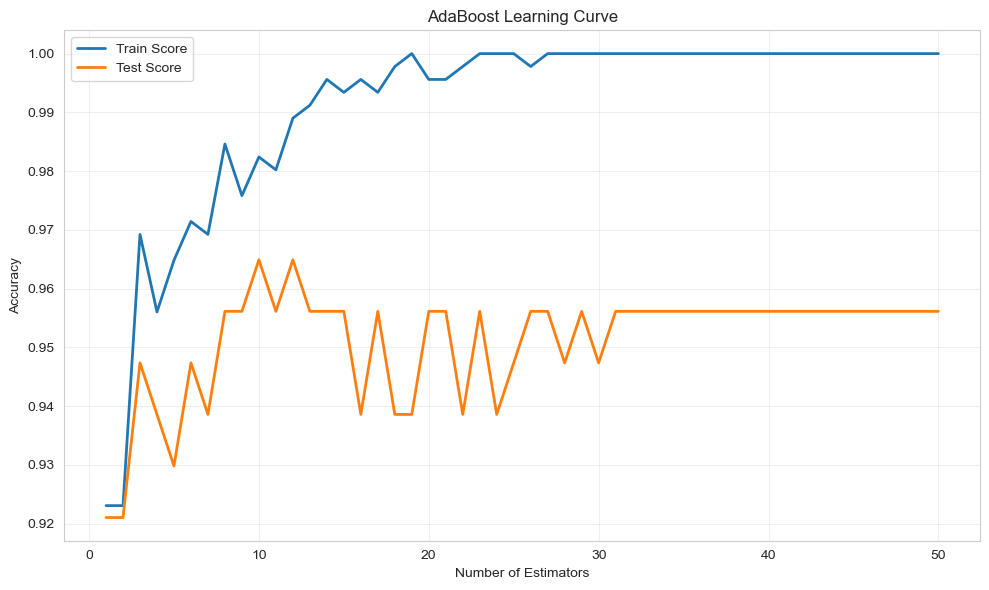


Best test score: 0.9649 at n_estimators=10

💡 Notice: Performance improves rapidly, then plateaus
   May eventually overfit if too many estimators


In [4]:
print("AdaBoost Staged Predictions")
print("="*70)

# Track performance as estimators are added
n_estimators_range = list(range(1, 51))
train_scores = []
test_scores = []

for n_est in n_estimators_range:
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=n_est,
        random_state=42
    )
    ada.fit(X_train, y_train)
    train_scores.append(ada.score(X_train, y_train))
    test_scores.append(ada.score(X_test, y_test))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Train Score', linewidth=2)
plt.plot(n_estimators_range, test_scores, label='Test Score', linewidth=2)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('AdaBoost Learning Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

best_n = n_estimators_range[np.argmax(test_scores)]
best_score = max(test_scores)
print(f"\nBest test score: {best_score:.4f} at n_estimators={best_n}")
print(f"\n💡 Notice: Performance improves rapidly, then plateaus")
print(f"   May eventually overfit if too many estimators")

### 1.3 Sample Weights Evolution

In [5]:
print("Sample Weights Visualization")
print("="*70)

# Train AdaBoost and access sample weights during training
# Note: sklearn doesn't expose intermediate weights, so we'll show final distribution

# Get staged predictions to find hard samples
ada_viz = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=10,
    random_state=42
)
ada_viz.fit(X_train, y_train)

# Identify misclassified samples
y_pred_train = ada_viz.predict(X_train)
errors = (y_pred_train != y_train)

print(f"Training samples: {len(y_train)}")
print(f"Misclassified: {errors.sum()} ({errors.sum()/len(y_train)*100:.1f}%)")

# Compare with single stump
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
stump_errors = (stump.predict(X_train) != y_train)

print(f"\nSingle stump misclassified: {stump_errors.sum()} ({stump_errors.sum()/len(y_train)*100:.1f}%)")
print(f"\n✓ AdaBoost reduced training errors significantly!")

print("\n💡 How AdaBoost works:")
print("   1. Easy samples get lower weights (downweighted)")
print("   2. Hard samples get higher weights (focused on)")
print("   3. Each new model tries to fix previous mistakes")

Sample Weights Visualization
Training samples: 455
Misclassified: 8 (1.8%)

Single stump misclassified: 35 (7.7%)

✓ AdaBoost reduced training errors significantly!

💡 How AdaBoost works:
   1. Easy samples get lower weights (downweighted)
   2. Hard samples get higher weights (focused on)
   3. Each new model tries to fix previous mistakes


### 1.4 AdaBoost for Regression

In [6]:
# Load diabetes dataset
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

print("AdaBoost Regression - Diabetes Dataset")
print("="*70)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_diabetes, y_diabetes, test_size=0.2, random_state=42
)

# Single tree
single_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
single_tree.fit(X_train_r, y_train_r)
y_pred_single = single_tree.predict(X_test_r)
r2_single = r2_score(y_test_r, y_pred_single)
rmse_single = np.sqrt(mean_squared_error(y_test_r, y_pred_single))

print(f"Single Tree (depth=3):")
print(f"  R² Score: {r2_single:.4f}")
print(f"  RMSE:     {rmse_single:.2f}")

# AdaBoost regressor
ada_reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
    learning_rate=1.0,
    loss='linear',  # 'linear', 'square', 'exponential'
    random_state=42
)

ada_reg.fit(X_train_r, y_train_r)
y_pred_ada = ada_reg.predict(X_test_r)
r2_ada = r2_score(y_test_r, y_pred_ada)
rmse_ada = np.sqrt(mean_squared_error(y_test_r, y_pred_ada))

print(f"\nAdaBoost (100 trees):")
print(f"  R² Score: {r2_ada:.4f}")
print(f"  RMSE:     {rmse_ada:.2f}")
print(f"\n✓ Improvement: R² +{r2_ada - r2_single:.4f}, RMSE -{rmse_single - rmse_ada:.2f}")

AdaBoost Regression - Diabetes Dataset
Single Tree (depth=3):
  R² Score: 0.3294
  RMSE:     59.60

AdaBoost (100 trees):
  R² Score: 0.4052
  RMSE:     56.14

✓ Improvement: R² +0.0758, RMSE -3.47


## 2. Gradient Boosting

### Intuition and Mathematics

**Key Idea**: Fit new models to the **residuals** (errors) of the ensemble.

**Algorithm**:

1. Initialize with constant prediction:
   \[
   F_0(x) = \arg\min_\gamma \sum_{i=1}^{n} L(y_i, \gamma)
   \]

2. For \(m = 1, 2, ..., M\):
   
   a. Compute pseudo-residuals:
   \[
   r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}}
   \]
   
   b. Fit weak learner \(h_m(x)\) to residuals \(r_{im}\)
   
   c. Find optimal step size:
   \[
   \gamma_m = \arg\min_\gamma \sum_{i=1}^{n} L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))
   \]
   
   d. Update model:
   \[
   F_m(x) = F_{m-1}(x) + \nu \gamma_m h_m(x)
   \]
   where \(\nu\) is the learning rate

**For Regression (squared loss)**:
- Residuals = actual - predicted
- Simply fit trees to errors!

**For Classification (log loss)**:
- Residuals = gradient of log loss
- Fit trees to probability gradients

### 2.1 Gradient Boosting Classification

In [7]:
print("Gradient Boosting Classification")
print("="*70)

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

gb_clf.fit(X_train, y_train)

train_acc_gb = gb_clf.score(X_train, y_train)
test_acc_gb = gb_clf.score(X_test, y_test)

print(f"Gradient Boosting:")
print(f"  Train Accuracy: {train_acc_gb:.4f}")
print(f"  Test Accuracy:  {test_acc_gb:.4f}")

# Compare with AdaBoost
print(f"\nComparison:")
print(f"  AdaBoost Test:     {test_acc:.4f}")
print(f"  Gradient Boost Test: {test_acc_gb:.4f}")
print(f"  Difference:        {test_acc_gb - test_acc:+.4f}")

Gradient Boosting Classification
Gradient Boosting:
  Train Accuracy: 1.0000
  Test Accuracy:  0.9561

Comparison:
  AdaBoost Test:     0.9561
  Gradient Boost Test: 0.9561
  Difference:        +0.0000


### 2.2 Learning Rate Effect

Effect of Learning Rate
LR=0.01: Train=0.9868, Test=0.9211, Overfit=0.0658
LR=0.05: Train=1.0000, Test=0.9474, Overfit=0.0526
LR=0.10: Train=1.0000, Test=0.9561, Overfit=0.0439
LR=0.50: Train=1.0000, Test=0.9561, Overfit=0.0439
LR=1.00: Train=1.0000, Test=0.9561, Overfit=0.0439


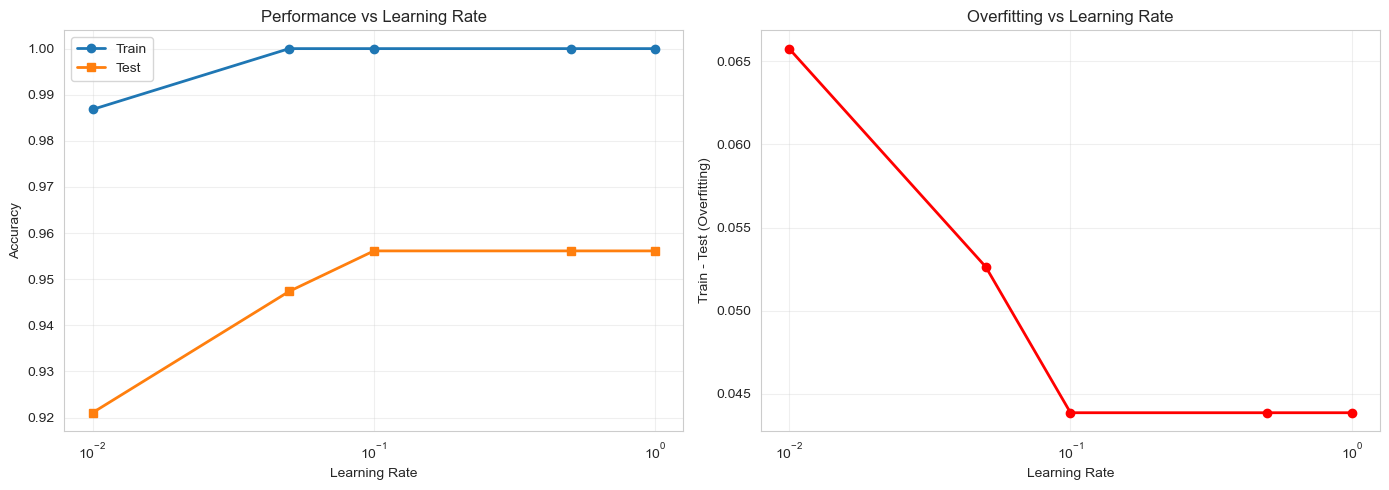


💡 Learning Rate Tradeoff:
   - High LR (1.0): Fast convergence, may overfit
   - Low LR (0.01): Slow convergence, better generalization
   - Need to increase n_estimators with lower learning rate
   - Typical: LR=0.1 with 100-1000 estimators


In [8]:
print("Effect of Learning Rate")
print("="*70)

learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]
results_lr = []

for lr in learning_rates:
    gb = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=lr,
        max_depth=3,
        random_state=42
    )
    gb.fit(X_train, y_train)
    
    train_score = gb.score(X_train, y_train)
    test_score = gb.score(X_test, y_test)
    
    results_lr.append({
        'Learning Rate': lr,
        'Train': train_score,
        'Test': test_score,
        'Overfit': train_score - test_score
    })
    
    print(f"LR={lr:.2f}: Train={train_score:.4f}, Test={test_score:.4f}, Overfit={train_score-test_score:.4f}")

# Plot
df_lr = pd.DataFrame(results_lr)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scores
axes[0].plot(df_lr['Learning Rate'], df_lr['Train'], 'o-', label='Train', linewidth=2)
axes[0].plot(df_lr['Learning Rate'], df_lr['Test'], 's-', label='Test', linewidth=2)
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Performance vs Learning Rate')
axes[0].set_xscale('log')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Overfitting
axes[1].plot(df_lr['Learning Rate'], df_lr['Overfit'], 'o-', linewidth=2, color='red')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Train - Test (Overfitting)')
axes[1].set_title('Overfitting vs Learning Rate')
axes[1].set_xscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Learning Rate Tradeoff:")
print("   - High LR (1.0): Fast convergence, may overfit")
print("   - Low LR (0.01): Slow convergence, better generalization")
print("   - Need to increase n_estimators with lower learning rate")
print("   - Typical: LR=0.1 with 100-1000 estimators")

### 2.3 Gradient Boosting Regression

Gradient Boosting Regression
Gradient Boosting:
  R² Score: 0.3791
  RMSE:     57.36

Comparison:
  Single Tree:    R²=0.3294, RMSE=59.60
  AdaBoost:       R²=0.4052, RMSE=56.14
  Gradient Boost: R²=0.3791, RMSE=57.36


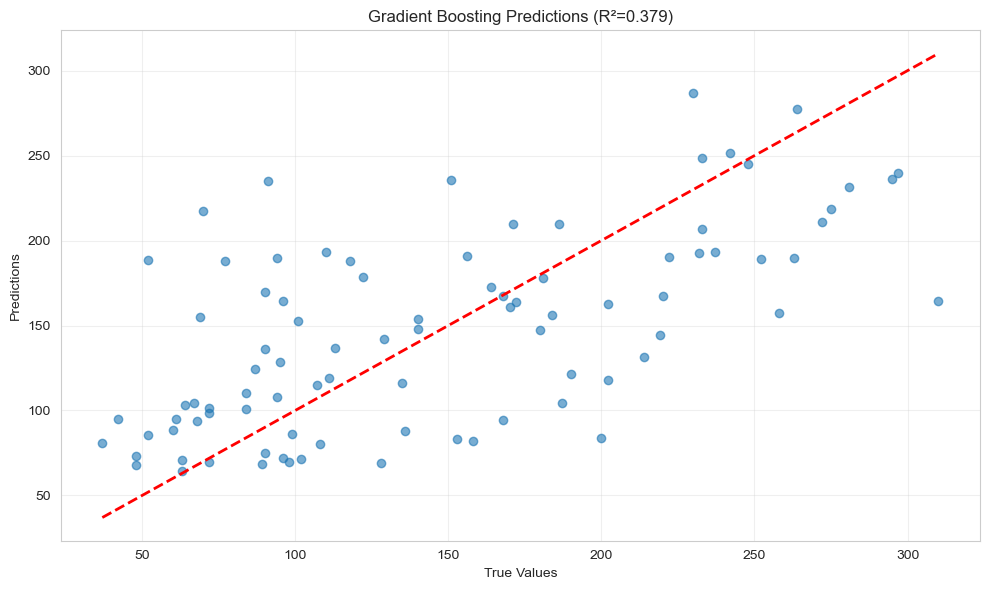

In [9]:
print("Gradient Boosting Regression")
print("="*70)

# Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,  # Stochastic gradient boosting
    random_state=42
)

gb_reg.fit(X_train_r, y_train_r)

y_pred_gb = gb_reg.predict(X_test_r)
r2_gb = r2_score(y_test_r, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test_r, y_pred_gb))

print(f"Gradient Boosting:")
print(f"  R² Score: {r2_gb:.4f}")
print(f"  RMSE:     {rmse_gb:.2f}")

print(f"\nComparison:")
print(f"  Single Tree:    R²={r2_single:.4f}, RMSE={rmse_single:.2f}")
print(f"  AdaBoost:       R²={r2_ada:.4f}, RMSE={rmse_ada:.2f}")
print(f"  Gradient Boost: R²={r2_gb:.4f}, RMSE={rmse_gb:.2f}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test_r, y_pred_gb, alpha=0.6)
plt.plot([y_test_r.min(), y_test_r.max()], 
         [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Gradient Boosting Predictions (R²={r2_gb:.3f})')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2.4 Staged Predictions (Residual Reduction)

Gradient Boosting Staged Predictions


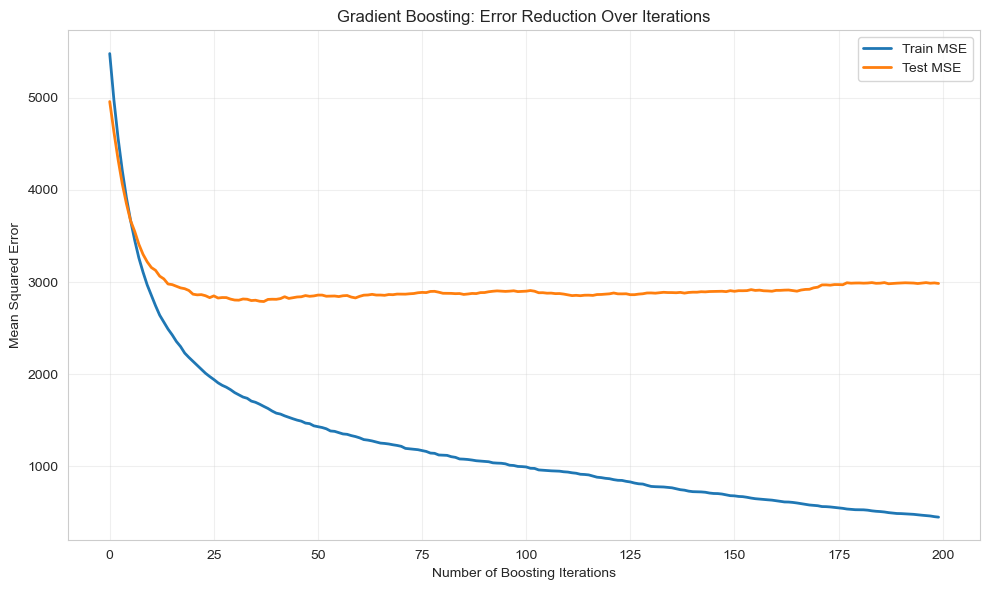


Best iteration: 38
Best test MSE: 2788.79

💡 Notice:
   - Train error decreases monotonically
   - Test error may increase after optimal point (overfitting)
   - Use early stopping or cross-validation to find best n_estimators


In [10]:
print("Gradient Boosting Staged Predictions")
print("="*70)

# Train GB with more estimators for visualization
gb_staged = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_staged.fit(X_train_r, y_train_r)

# Get predictions at each stage
train_scores_staged = []
test_scores_staged = []

for i, (train_pred, test_pred) in enumerate(zip(
    gb_staged.staged_predict(X_train_r),
    gb_staged.staged_predict(X_test_r)
)):
    train_scores_staged.append(mean_squared_error(y_train_r, train_pred))
    test_scores_staged.append(mean_squared_error(y_test_r, test_pred))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_scores_staged, label='Train MSE', linewidth=2)
plt.plot(test_scores_staged, label='Test MSE', linewidth=2)
plt.xlabel('Number of Boosting Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Gradient Boosting: Error Reduction Over Iterations')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

best_iter = np.argmin(test_scores_staged) + 1
best_mse = min(test_scores_staged)

print(f"\nBest iteration: {best_iter}")
print(f"Best test MSE: {best_mse:.2f}")
print(f"\n💡 Notice:")
print("   - Train error decreases monotonically")
print("   - Test error may increase after optimal point (overfitting)")
print("   - Use early stopping or cross-validation to find best n_estimators")

### 2.5 Feature Importance

Gradient Boosting Feature Importance
Feature  Importance
    bmi    0.351935
     s5    0.216701
     bp    0.113379
     s2    0.067471
     s6    0.061915
     s1    0.056158
    age    0.055322
     s3    0.039401
     s4    0.022842
    sex    0.014876


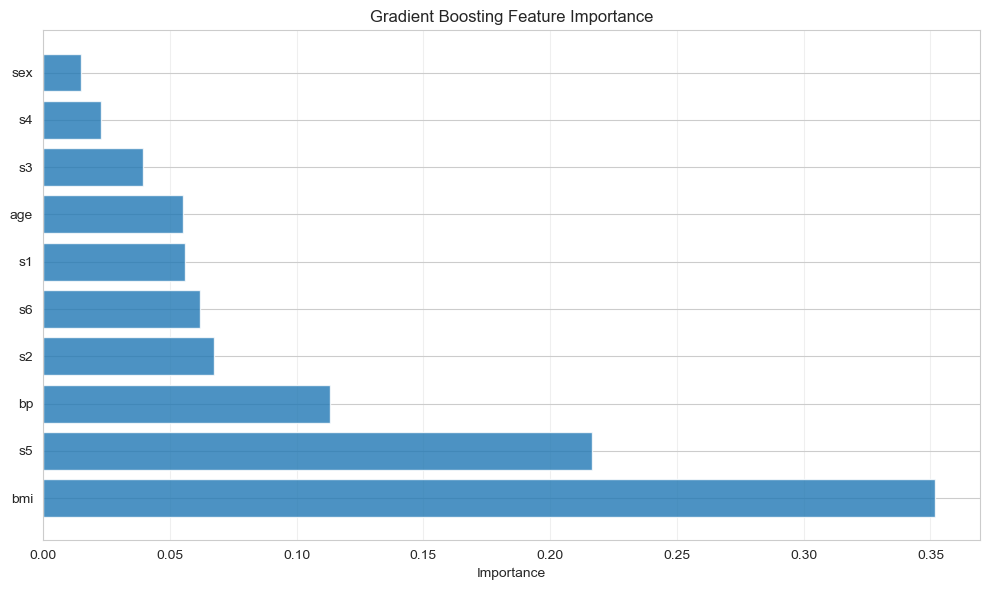


💡 Feature importance in boosting:
   - Based on total reduction in loss from splits on that feature
   - Aggregated across all trees in the ensemble
   - More splits on a feature = higher importance


In [11]:
print("Gradient Boosting Feature Importance")
print("="*70)

# Feature importance
feature_importance = gb_reg.feature_importances_
feature_names = diabetes.feature_names

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(importance_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], alpha=0.8)
plt.xlabel('Importance')
plt.title('Gradient Boosting Feature Importance')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n💡 Feature importance in boosting:")
print("   - Based on total reduction in loss from splits on that feature")
print("   - Aggregated across all trees in the ensemble")
print("   - More splits on a feature = higher importance")

## 3. Comprehensive Comparison

### 3.1 AdaBoost vs Gradient Boosting vs Bagging

In [12]:
print("Comprehensive Ensemble Comparison")
print("="*70)

# Load wine dataset for multiclass
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_wine, y_wine, test_size=0.3, random_state=42, stratify=y_wine
)

# Define models
models = {
    'Single Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Bagging': BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    'AdaBoost': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=100,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
}

results_comparison = []

for name, model in models.items():
    # Train
    model.fit(X_train_w, y_train_w)
    
    # Evaluate
    train_score = model.score(X_train_w, y_train_w)
    test_score = model.score(X_test_w, y_test_w)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_wine, y_wine, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results_comparison.append({
        'Model': name,
        'Train': train_score,
        'Test': test_score,
        'CV Mean': cv_mean,
        'CV Std': cv_std,
        'Overfit': train_score - test_score
    })
    
    print(f"\n{name}:")
    print(f"  Train: {train_score:.4f}")
    print(f"  Test:  {test_score:.4f}")
    print(f"  CV:    {cv_mean:.4f} ± {cv_std:.4f}")

# Summary table
df_comparison = pd.DataFrame(results_comparison)
print("\n" + "="*70)
print("Summary:")
print(df_comparison.to_string(index=False))

Comprehensive Ensemble Comparison

Single Tree:
  Train: 1.0000
  Test:  0.9630
  CV:    0.8654 ± 0.0440

Bagging:
  Train: 1.0000
  Test:  1.0000
  CV:    0.9554 ± 0.0376

Random Forest:
  Train: 1.0000
  Test:  1.0000
  CV:    0.9721 ± 0.0176

AdaBoost:
  Train: 1.0000
  Test:  0.9815
  CV:    0.9278 ± 0.0648

Gradient Boosting:
  Train: 1.0000
  Test:  0.9630
  CV:    0.9386 ± 0.0321

Summary:
            Model  Train     Test  CV Mean   CV Std  Overfit
      Single Tree    1.0 0.962963 0.865397 0.044036 0.037037
          Bagging    1.0 1.000000 0.955397 0.037611 0.000000
    Random Forest    1.0 1.000000 0.972063 0.017571 0.000000
         AdaBoost    1.0 0.981481 0.927778 0.064788 0.018519
Gradient Boosting    1.0 0.962963 0.938571 0.032068 0.037037


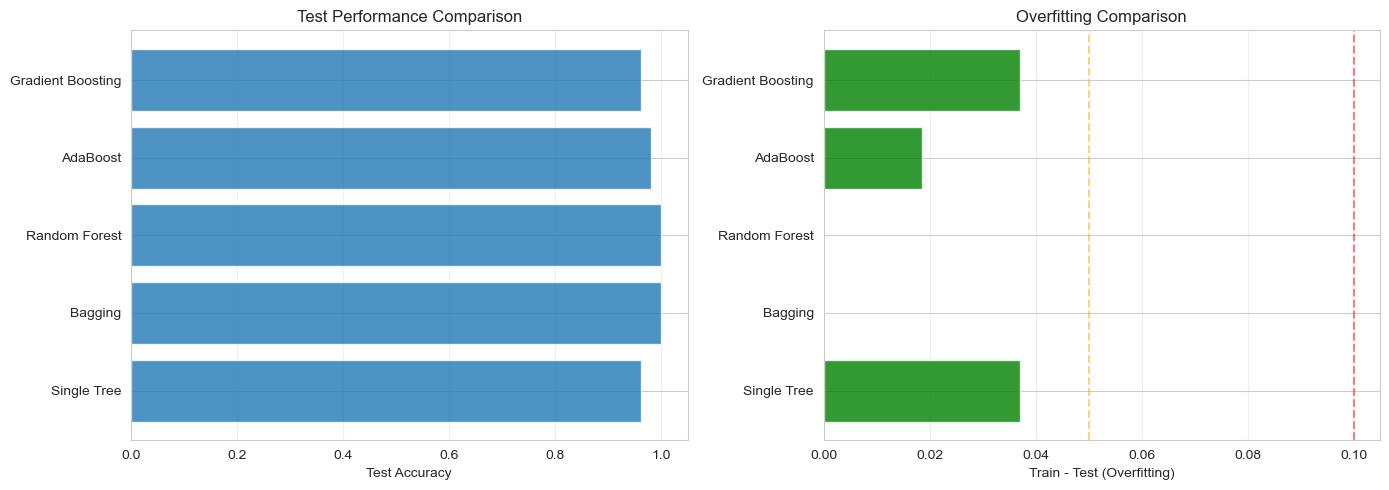


💡 Key Observations:
   - Boosting methods (AdaBoost, GB) often achieve highest accuracy
   - Bagging methods (RF, Bagging) show less overfitting
   - Single tree overfits most
   - Gradient Boosting typically best but requires tuning


In [13]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test scores
axes[0].barh(df_comparison['Model'], df_comparison['Test'], alpha=0.8)
axes[0].set_xlabel('Test Accuracy')
axes[0].set_title('Test Performance Comparison')
axes[0].grid(alpha=0.3, axis='x')

# Overfitting
colors = ['green' if x < 0.05 else 'orange' if x < 0.1 else 'red' 
          for x in df_comparison['Overfit']]
axes[1].barh(df_comparison['Model'], df_comparison['Overfit'], color=colors, alpha=0.8)
axes[1].set_xlabel('Train - Test (Overfitting)')
axes[1].set_title('Overfitting Comparison')
axes[1].axvline(x=0.05, color='orange', linestyle='--', alpha=0.5)
axes[1].axvline(x=0.1, color='red', linestyle='--', alpha=0.5)
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("   - Boosting methods (AdaBoost, GB) often achieve highest accuracy")
print("   - Bagging methods (RF, Bagging) show less overfitting")
print("   - Single tree overfits most")
print("   - Gradient Boosting typically best but requires tuning")

## 4. Hyperparameter Tuning Guide

### 4.1 Key Parameters

In [14]:
print("Boosting Hyperparameters Guide")
print("="*70)

hyperparams = """
AdaBoost Parameters:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
n_estimators:     Number of weak learners
  Default: 50
  Range: 50-500
  Effect: More = better, diminishing returns

learning_rate:    Shrinks contribution of each classifier
  Default: 1.0
  Range: 0.01-1.0
  Effect: Lower = needs more estimators, better generalization

estimator:        Base weak learner
  Default: DecisionTreeClassifier(max_depth=1)
  Typical: Decision stumps (depth=1) or shallow trees (depth=2-3)

Gradient Boosting Parameters:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
n_estimators:     Number of boosting stages
  Default: 100
  Range: 50-1000+
  Effect: More = better until overfitting
  💡 Use early stopping or staged predictions

learning_rate:    Shrinks contribution of each tree
  Default: 0.1
  Range: 0.01-0.3
  Effect: Lower = more robust, needs more estimators
  💡 Typical: 0.1 with 100-500 estimators, or 0.01 with 1000+

max_depth:        Maximum depth of trees
  Default: 3
  Range: 2-8
  Effect: Controls model complexity
  💡 Shallow trees work best (3-5)

subsample:        Fraction of samples for each tree
  Default: 1.0
  Range: 0.5-1.0
  Effect: < 1.0 = Stochastic GB, reduces variance
  💡 0.8 often works well

min_samples_split: Minimum samples to split node
  Default: 2
  Range: 2-20
  Effect: Higher = more regularization

min_samples_leaf: Minimum samples in leaf
  Default: 1
  Range: 1-20
  Effect: Higher = smoother predictions

max_features:     Features to consider for splits
  Default: None (all features)
  Options: 'sqrt', 'log2', int, float
  Effect: Adds randomness, can improve generalization
"""

print(hyperparams)

Boosting Hyperparameters Guide

AdaBoost Parameters:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
n_estimators:     Number of weak learners
  Default: 50
  Range: 50-500
  Effect: More = better, diminishing returns

learning_rate:    Shrinks contribution of each classifier
  Default: 1.0
  Range: 0.01-1.0
  Effect: Lower = needs more estimators, better generalization

estimator:        Base weak learner
  Default: DecisionTreeClassifier(max_depth=1)
  Typical: Decision stumps (depth=1) or shallow trees (depth=2-3)

Gradient Boosting Parameters:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
n_estimators:     Number of boosting stages
  Default: 100
  Range: 50-1000+
  Effect: More = better until overfitting
  💡 Use early stopping or staged predictions

learning_rate:    Shrinks contribution of each tree
  Default: 0.1
  Range: 0.01-0.3
  Effect: Lower = more robust, needs more estimators
  💡 Typical: 0.1 with 100-500 estimators, or 0.01 with 10

## 5. When to Use Which Algorithm

### 5.1 Decision Guide

In [15]:
print("Algorithm Selection Guide")
print("="*70)

guide = """
Use ADABOOST when:
✓ Simple interpretability needed (weights show sample difficulty)
✓ Binary classification with well-separated classes
✓ Quick baseline ensemble method
✓ Data has few outliers (AdaBoost sensitive to outliers)
✗ Data is noisy or has many outliers
✗ Computational resources are very limited

Use GRADIENT BOOSTING when:
✓ Maximum accuracy is priority
✓ Willing to tune hyperparameters carefully
✓ Have computational resources for training
✓ Need flexible loss functions
✓ Can use cross-validation or early stopping
✗ Need very fast predictions (deep trees = slower)
✗ Cannot tune hyperparameters

Use BAGGING/RANDOM FOREST when:
✓ Want robust model with less tuning
✓ Need fast training (parallel)
✓ High variance model (deep trees)
✓ Want to reduce overfitting
✗ Model has high bias (underfits)

General Hierarchy (for trees):
1. Try Random Forest first (robust baseline)
2. Try Gradient Boosting for better accuracy
3. Try modern boosting (XGBoost, LightGBM, CatBoost)
4. AdaBoost as alternative for binary classification

Performance Ranking (typical):
XGBoost/LightGBM > Gradient Boosting > AdaBoost ≈ Random Forest > Bagging > Single Tree

Training Speed:
Random Forest (parallel) > Bagging > AdaBoost > Gradient Boosting

Resistance to Overfitting:
Random Forest > Bagging > Gradient Boosting (with tuning) > AdaBoost > Single Tree
"""

print(guide)

Algorithm Selection Guide

Use ADABOOST when:
✓ Simple interpretability needed (weights show sample difficulty)
✓ Binary classification with well-separated classes
✓ Quick baseline ensemble method
✓ Data has few outliers (AdaBoost sensitive to outliers)
✗ Data is noisy or has many outliers
✗ Computational resources are very limited

Use GRADIENT BOOSTING when:
✓ Maximum accuracy is priority
✓ Willing to tune hyperparameters carefully
✓ Have computational resources for training
✓ Need flexible loss functions
✓ Can use cross-validation or early stopping
✗ Need very fast predictions (deep trees = slower)
✗ Cannot tune hyperparameters

Use BAGGING/RANDOM FOREST when:
✓ Want robust model with less tuning
✓ Need fast training (parallel)
✓ High variance model (deep trees)
✓ Want to reduce overfitting
✗ Model has high bias (underfits)

General Hierarchy (for trees):
1. Try Random Forest first (robust baseline)
2. Try Gradient Boosting for better accuracy
3. Try modern boosting (XGBoost, LightG

## Summary and Best Practices

### Quick Reference

```python
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Stump
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

# Staged predictions for early stopping
for i, pred in enumerate(gb.staged_predict(X_test)):
    if early_stopping_condition:
        break
```

### Key Differences

| Aspect | AdaBoost | Gradient Boosting | Bagging/RF |
|--------|----------|-------------------|------------|
| Training | Sequential | Sequential | Parallel |
| Reduces | Bias | Bias | Variance |
| Base Model | Weak (stumps) | Weak (shallow) | Strong (deep) |
| Weights | Sample weights | Residuals | Equal |
| Overfitting | Resistant | Prone (needs tuning) | Resistant |
| Speed | Medium | Slow | Fast |
| Accuracy | Good | Excellent | Good |

### Best Practices

**AdaBoost:**
1. ✓ Start with stumps (max_depth=1)
2. ✓ Try 50-200 estimators
3. ✓ Lower learning_rate if overfitting
4. ✓ Remove outliers first

**Gradient Boosting:**
1. ✓ Start with: `n_estimators=100, learning_rate=0.1, max_depth=3`
2. ✓ Use `subsample=0.8` for stochastic GB
3. ✓ Monitor staged predictions for overfitting
4. ✓ Lower learning_rate + more estimators = better generalization
5. ✓ Use cross-validation to find optimal n_estimators
6. ✓ Keep trees shallow (depth 3-5)

### Common Mistakes

1. ❌ Using deep base learners with AdaBoost
2. ❌ Not tuning learning_rate
3. ❌ Too many estimators without validation
4. ❌ Using boosting when bagging would suffice
5. ❌ Not standardizing features (for some implementations)
6. ❌ Ignoring outliers in AdaBoost

### Next Steps

- XGBoost, LightGBM, CatBoost (advanced boosting)
- Stacking and Voting ensembles
- Hyperparameter optimization (GridSearch, RandomSearch, Bayesian)
- Feature engineering for boosting
- Early stopping techniques